# The Min–Max theorem

As described in the 18.303 [class notes](https://github.com/mitmath/18303/blob/fall16/minmax.pdf), the min–max theorem (or "variational theorem") says that, for a self-adjoint operator $\hat{A}$ under some inner product $\langle u, v \rangle$ on some Sobolev space $u,v \in V$ (essentially, $u,v$ such that the "bilinear form" $\langle u, \hat{A} v \rangle$ is finite), the **Rayleigh quotient**
$$
R\{u\} = \frac{\langle u, \hat{A} u \rangle}{\langle u, u \rangle}
$$
evaluated for *any* $u \ne 0$ in $V$ is an upper bound for the minimum eigenvalue of $\hat{A}$ (if any) and a lower bound for the maximum eigenvalue of $\hat{A}$ (if any).  Furthermore, the eigenvalues of $\hat{A}$ are *extrema* of $R\{u\}$.

As described in the notes, this allows us to easily guess the qualitative features of the first few eigenvalues of an operator, even in cases that we can't easily solve analytically.

In [1]:
using SparseArrays, LinearAlgebra # packages in the Julia standard library
using Arpack, PyPlot, Interact    # packages you need to install

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/0970407a089b1a08d50de9a01fe0925692591a88-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/0970407a089b1a08d50de9a01fe0925692591a88-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Finite-difference discretization

As an example, let's consider $\hat{A} = -\nabla\cdot c\nabla$ for some $c(\vec{x}) > 0$, which is self-adjoint and positive-definite for any finite domain $\Omega$ with Dirichlet boundary conditions $u|_{\partial\Omega}=0$ and the usual inner product $\langle u, v \rangle = \int_\Omega \bar{u} v$.

We'll define the finite-difference discretization by code that is a bit
more general than we have used before: we'll allow the user to pass
in 1d arrays `x` and `y` of the $x$ and $y$ coordinates used in the
discretization (possibly nonuniformly spaced!), *including* the coordinates of the endpoints where $u$ is zero.  We'll also allow the user to pass in an arbitrary *function* $c(x,y)$ that we'll evaluate on the grid as needed.

In [2]:
# compute the first-derivative finite-difference matrix
# for Dirichlet boundaries, given a grid x[:] of x points
# (including the endpoints where the function = 0!).
function sdiff1(x)
    N = length(x) - 2
    dx1 = Float64[1/(x[i+1] - x[i]) for i = 1:N]
    dx2 = Float64[-1/(x[i+1] - x[i]) for i = 2:N+1]
    I, J, V = SparseArrays.spdiagm_internal(0=>dx1, -1=>dx2)
    return sparse(I, J, V, N+1,N)
end

# compute the -∇⋅ c ∇ operator for a function c(x,y)
# and arrays x[:] and y[:] of the x and y points,
# including the endpoints where functions are zero
# (i.e. Dirichlet boundary conditions).
function Laplacian(x, y, c)
    Dx = sdiff1(x)
    Nx = size(Dx,2)
    Dy = sdiff1(y)
    Ny = size(Dy,2)
    
    # discrete gradient operator:
    G = [kron(sparse(I,Ny,Ny), Dx); kron(Dy, sparse(I,Nx,Nx))]
    
    # grids for derivatives in x and y directions
    x′ = [0.5*(x[i]+x[i+1]) for i = 1:length(x)-1]
    y′ = [0.5*(y[i]+y[i+1]) for i = 1:length(y)-1]
    
    # evaluate c(x)
    C = spdiagm(0 => [ vec([c(X,Y) for X in x′, Y in y[2:end-1]]);
                       vec([c(X,Y) for X in x[2:end-1], Y in y′]) ])
    
    return G' * C * G # -∇⋅ c ∇
end

Laplacian (generic function with 1 method)

As a quick check to make sure this is working, let's do $\hat{A}=-\nabla^2$ on the box $[0,1]\times[0,1]$, and verify that it gives the expected separable solution and first eigenvalue $2\pi^2$:

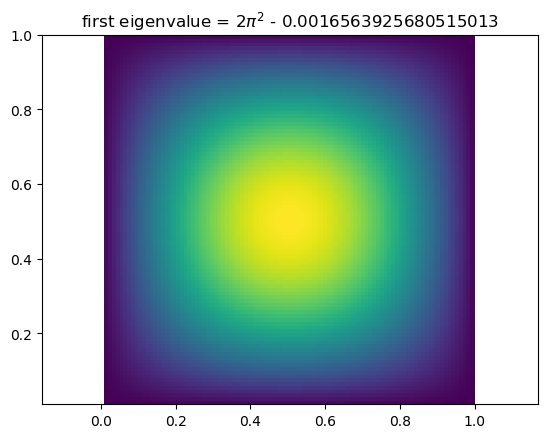

PyObject Text(0.5, 1.0, 'first eigenvalue = $2\\pi^2$ - 0.0016563925680515013')

In [3]:
x = range(0,stop=1,length=100)
A = Laplacian(x, x, (x,y) -> 1.0)

λ, X = eigs(A, nev=1, which=:SM)

U = reshape(X[:,1],98,98)
pcolor(x[2:end]',x[2:end],U)
axis("equal")
title("first eigenvalue = \$2\\pi^2\$ - $(2π^2 - λ[1])")

## Min-max Example 1: $-\nabla^2$ in an odd-shaped domain

First, let's consider the usual $-\nabla^2$ operator, but use an oddly shaped domain, using the trick from our previous Kronecker notes of defining a discretization over a box and then taking a subset of rows and columns that are inside our domain.

We'll define an odd spiral-shaped domain as the intersection of the box $[-1,1]\times[-1,1]$ with the region where a [level-set function](https://en.wikipedia.org/wiki/Level_set_method) $\varphi(x,y)$ is $>0$.

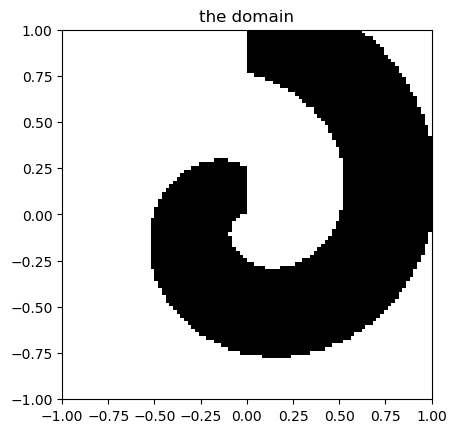

PyObject Text(0.5, 1.0, 'the domain')

In [4]:
N = 100
x = range(-1,stop=1,length=N+2)[2:end-1]
y = x'  # a row vector
r = @. sqrt(x^2 + y^2)     # use broadcasting (@.) to make Nx x Ny matrix of radii
θ = atan.(y, x) # and angles
φ = @. exp(-(r - θ*0.5/π - 0.5)^2 / 0.3^2) - 0.5
imshow(φ .> 0, extent=[-1,1,-1,1], cmap="binary")
title("the domain")

Now we'll compute the eigenfunctions.  We'll use the [Interact package](https://github.com/JuliaLang/Interact.jl) to interactively decide which eigenvalue to plot.

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-a062cf6e-3d04-4eed-82b8-d1e00f54ec31", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["which_eig"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>20,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"value: indexString, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"indexString"=>(Observable{String} with 1 listeners. Value:
"10", nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Any["knockout"=>"/Users/stevenj/.julia/packages/Knockout/fe7U3/src/../assets/knockout.js", "knockout_punches"=>"/Users/stevenj/.julia/packages/Knockout/fe7U3/src/../assets/knockout_punches.js", "/Users/stevenj/.julia/packages/InteractBase/yFw0W/src/../assets/all.js", "/Users/stevenj/.julia/packages/InteractBase/yFw0W/src/../assets/style.css", "/Users/stevenj/.julia/packages/InteractBulma/PH56C/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"1\\\",\\\"2\\\",\\\"3\\\",\\\"4\\\",\\\"5\\\",\\\"6\\\",\\\"7\\\",\\\"8\\\",\\\"9\\\",\\\"10\\\",\\\"11\\\",\\\"12\\\",\\\"13\\\",\\\"14\\\",\\\"15\\\",\\\"16\\\",\\\"17\\\",\\\"18\\\",\\\"19\\\",\\\"20\\\"],\\\"changes\\\":0,\\\"indexString\\\":\\\"10\\\",\\\"index\\\":10}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"formatted_val\"]=ko.computed(    function(){\n        return this.formatted_vals()[parseInt(this.index())-1];\n    }\n,this)]\n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-a062cf6e-3d04-4eed-82b8-d1e00f54ec31\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"indexString\"].subscribe((function (val){!(this.valueFromJ
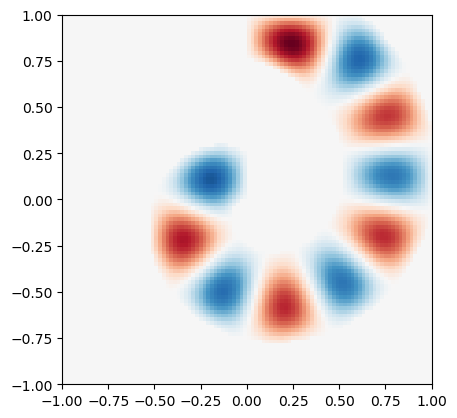
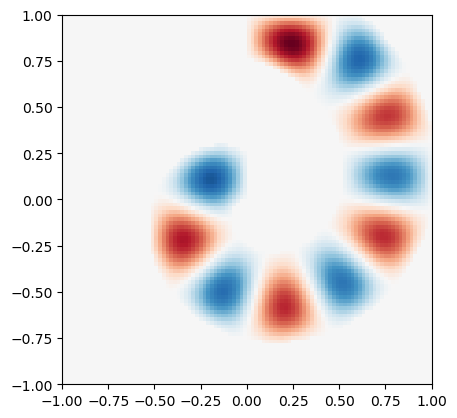

In [5]:
x0 = range(-1,stop=1,length=N+2) # includes boundary points, unlike x
Abox = Laplacian(x0, x0, (x,y) -> 1.0)
i = findall(vec(φ) .> 0)
A = Abox[i,i]
u = zeros(N,N)
λ, X = eigs(A, nev=20, which=:SM)

f = figure()
@manipulate for which_eig in 1:20
    withfig(f) do
        u[i] = X[:,which_eig]
        umax = maximum(abs, u)
        imshow(u, extent=[-1,1,-1,1], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

## Min-max Example 2: $-\nabla \cdot c \nabla$ for non-constant $c$


Now, let's do the box example, but with a non-constant $c$: let $c(x,y) = c_0$ for $x^2 + y^2 < 0.3^2$, and $= 1$ otherwise, and let's see what happens as we vary $c_0$.

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope("knockout-component-2a9cf607-fbf9-4886-a82e-3d1931fb0b79", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["log10_c0"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row-left"), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>41,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"value: indexString, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-center"), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")), 0)], Dict{Symbol,Any}(:className=>"interact-flex-row-right"), 1)], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget"), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"indexString"=>(Observable{String} with 1 listeners. Value:
"21", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
21, nothing)), Set(String[]), nothing, Any["knockout"=>"/Users/stevenj/.julia/packages/Knockout/fe7U3/src/../assets/knockout.js", "knockout_punches"=>"/Users/stevenj/.julia/packages/Knockout/fe7U3/src/../assets/knockout_punches.js", "/Users/stevenj/.julia/packages/InteractBase/yFw0W/src/../assets/all.js", "/Users/stevenj/.julia/packages/InteractBase/yFw0W/src/../assets/style.css", "/Users/stevenj/.julia/packages/InteractBulma/PH56C/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"-2.0\\\",\\\"-1.9\\\",\\\"-1.8\\\",\\\"-1.7\\\",\\\"-1.6\\\",\\\"-1.5\\\",\\\"-1.4\\\",\\\"-1.3\\\",\\\"-1.2\\\",\\\"-1.1\\\",\\\"-1.0\\\",\\\"-0.9\\\",\\\"-0.8\\\",\\\"-0.7\\\",\\\"-0.6\\\",\\\"-0.5\\\",\\\"-0.4\\\",\\\"-0.3\\\",\\\"-0.2\\\",\\\"-0.1\\\",\\\"0.0\\\",\\\"0.1\\\",\\\"0.2\\\",\\\"0.3\\\",\\\"0.4\\\",\\\"0.5\\\",\\\"0.6\\\",\\\"0.7\\\",\\\"0.8\\\",\\\"0.9\\\",\\\"1.0\\\",\\\"1.1\\\",\\\"1.2\\\",\\\"1.3\\\",\\\"1.4\\\",\\\"1.5\\\",\\\"1.6\\\",\\\"1.7\\\",\\\"1.8\\\",\\\"1.9\\\",\\\"2.0\\\"],\\\"changes\\\":0,\\\"indexString\\\":\\\"21\\\",\\\"index\\\":21}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"formatted_val\"]=ko.computed(    function(){\n        return this.formatted_vals()[parseInt(this.index())-1];\n    }\n,this)]\n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"ch
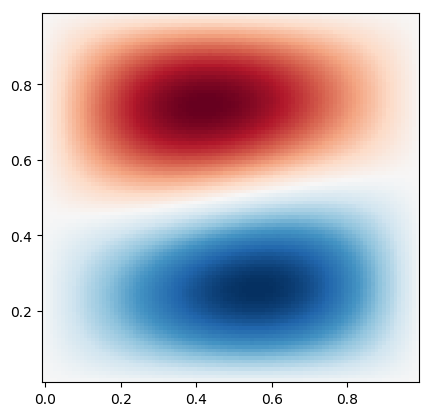
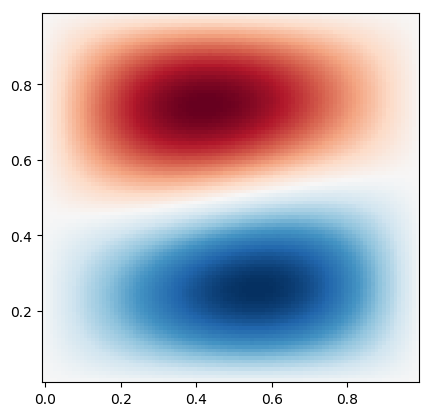

In [6]:
f = figure()
N = 100
x = range(0,stop=1,length=N+2)
R = 0.3
@manipulate for log10_c0 in -2:0.1:2, which_eig in 1:6
    withfig(f) do
        c0 = 10.0^log10_c0
        A = Laplacian(x, x, (x,y) -> x^2+y^2 < R^2 ? c0 : 1.0)
        λ, X = eigs(A, nev=which_eig, which=:SM)
        u = reshape(X[:,which_eig], N, N)
        umax = maximum(abs, u)
        imshow(u, extent=[-x[2],x[end-1],x[2],x[end-1]], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

What we see is that the small-λ solutions "want" to be in the region of small $c$.  So, if we
make $c_0$ very small, the solution gets "pulled into" the corner of $c_0$.  Conversely, if we make $c_0$ very large, then the solution is "pushed out of" the corner.

This is consistent with the min-max theorem, which says that the smallest eigenvalues of this operator minimize:
$$
R\{u\} = \frac{\int_\Omega c\Vert\nabla u\Vert^2}{\int_\Omega \Vert u\Vert^2}
$$
which clearly indicates that they want to (a) oscillate as little as possible while (b) concentrating in the regions where $c$ is smallest.